<a href="https://colab.research.google.com/github/fcarrir/EY_Dio/blob/main/Audiodescr%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Audiodescrição
Projeto objetiva oferecer recurso de acessibilidade para que pessoas com deficiência visual possam assistir e entender melhor imagens ou filmes, peças de teatro, programas de TV, exposições, mostras, musicais, óperas e outros, ouvindo o que pode ser visto. Audiodescrição é a arte de transformar aquilo que é visto no que é ouvido, o que abre muitas janelas do mundo para as pessoas com deficiência visual.
Nessa primeira etapa de prototipagem será abordado apenas o processo de audiodescrição de imagens estáticas, como forma de validação da idéia.
No projeto optou-se por utilizar uma rede SSD. Pro esse motivo selecionou-se a rede resnet50_v1_voc além da rede já possuir 20 objetos pré treinados ela possui uma acurácia satisfatória para o experimento.

###Instalação das bibliotecas necessárias

In [ ]:
# Instalando as bibliotecas 
!pip install gluoncv mxnet
!pip install gTTS

###Importação dos pacotes de bibliotecas

In [5]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import numpy as np
from itertools import groupby
from collections import Counter
from gtts import gTTS
from IPython.display import Audio

###Download das imagens

In [45]:
# Baixando imagem usada para teste 
!wget -O image.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6n0OBoXrrjOGjMoB_V2oyQH1FbXkBRUatgQ&usqp=CAU
#!wget -O image.jpg https://catracalivre.com.br/wp-content/uploads/2018/06/beneficios-de-andar-de-bicicleta-istock.jpg
#!wget -O image.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRQItIZrSjjotPqAlDZpAFXAcOnOk__o99iRA&usqp=CAU
#!wget -O image.jpg https://noticiasdecampinas.com.br/wp-content/uploads/2022/08/carro-e-onibus-batem-de-frente-e-tres-pessoas-ficam-feridas-em-campinas.jpg
#!wget -O image.jpg#!wget -O image.jpg https://i.ytimg.com/vi/tp_N4jv1Mhs/maxresdefault.jpg
#!wget -O image.jpg https://i.ytimg.com/vi/_G8ctdLaWbs/maxresdefault.jpg
#!wget -O image.jpg http://s2.glbimg.com/XthNYYF92iM2x5gLso6GvOB47RA=/620x455/e.glbimg.com/og/ed/f/original/2016/05/31/sala-cozinha-madeira-mesa-de-jantar-cadeira-sofa-tv.jpg 

--2022-10-24 15:29:38--  http://s2.glbimg.com/XthNYYF92iM2x5gLso6GvOB47RA=/620x455/e.glbimg.com/og/ed/f/original/2016/05/31/sala-cozinha-madeira-mesa-de-jantar-cadeira-sofa-tv.jpg
Resolving s2.glbimg.com (s2.glbimg.com)... 186.192.91.9
Connecting to s2.glbimg.com (s2.glbimg.com)|186.192.91.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59414 (58K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  58.02K   248KB/s    in 0.2s    

2022-10-24 15:29:39 (248 KB/s) - ‘image.jpg’ saved [59414/59414]



###Utilização do modelo pré-treinado ssd_512_resnet50_v1_voc

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


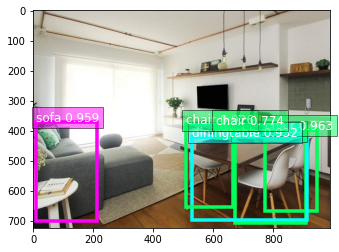

In [46]:
net = model_zoo.get_model('ssd_512_resnet50_v1_voc',pretrained=True)

x, img = data.transforms.presets.ssd.load_test('image.jpg', short=724)

class_IDs, scores, bounding_boxs = net(x)

utils.viz.plot_bbox(img, bounding_boxs[0],scores[0], class_IDs[0], class_names=net.classes)

###Conversão da lista de inglês para o português

In [47]:
net.classes = ('Avião', 'Bicicleta', 'Pássaro', 'Barco', 'Garrafa', 'Onibus', 'Carro', 'Gato', 'Cadeira', 'Vaca', 'Mesa de Jantar', 'Cachorro', 'Cavalo', 'Moto', 'Pessoa', 'Vaso de Planta', 'Ovelha', 'Sofá', 'Trem', 'TV')

###Contagem dos objetos identificados na imagem

In [48]:
lista = []
for i in range(class_IDs[0].size):
  if scores[0, i]>0.5:
    a = class_IDs[0, i].astype(int)
    lista.append(net.classes[a.squeeze().asnumpy().tolist()[0]])

lista.sort()
dic = {}

for obj in lista:
  if obj in dic:
    count = count + 1
  else:
    count =  1
  dic[obj] = count

print(dic)

{'Cadeira': 4, 'Mesa de Jantar': 1, 'Sofá': 1}


###Transcrição dos objetos em escrita textual

In [49]:
audio_description = 'A cena é composta por '

count = len(dic.keys())
for chave in dic.keys():
  if dic[chave] == 1:
    if chave[-1:] == 'a':
      audio_description += f'uma {chave}'
    else:
      audio_description += f'{dic[chave]} {chave}'  
  else:
    audio_description += f'{dic[chave]} {chave}'  
    audio_description += 's'
  count -= 1
  if count > 1:
    audio_description += ', '
  elif count == 1:
    audio_description += ' e '
print(audio_description)

A cena é composta por 4 Cadeiras, 1 Mesa de Jantar e 1 Sofá


###Reprodução em audio do cenário da imagem

In [50]:
language = 'pt'
gtts_object = gTTS(text = audio_description, lang=language, slow=False)
gtts_object.save('/content/gtts.wav')
Audio('/content/gtts.wav', autoplay=True)